Group 01:

-Valentina Tonazzo

-Elena Zoppellari

-Sebastiano Monti

-Germán Cano Amaro

# DNN: analysis with Keras of 2D data

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.losses import *
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import preprocessing

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

%run nonlinear_function.py #per cambiare cartella da cui prendere i dati, bisogna cambiare nome in questa funzione.

# training data
perc_train = 0.8 #to prevent overfitting -> JUST A TRY

2
[-31.60811883 -29.54397214] 1.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200


<function matplotlib.pyplot.show(close=None, block=None)>

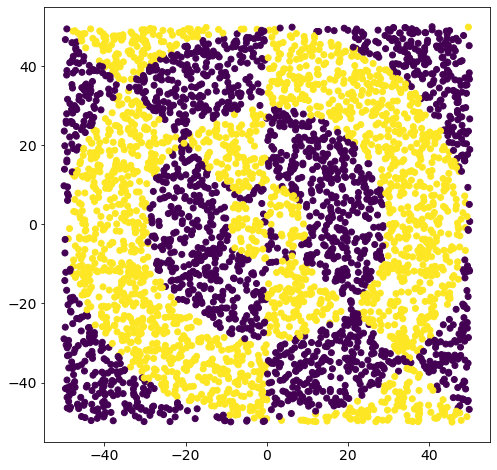

In [2]:
# Keras works with numpy arrays: just use them from the start
TYPE=2
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (8,8))
plt.scatter(x[:,0],x[:,1],c=y) #tutte le righe della colonna 0, tutte le righe della colonna 1
plt.show

### Split training and test data

In [28]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


### Rescale input data

In [29]:
def Rescale(x):
    #scaler = preprocessing.MaxAbsScaler().fit(x)
    #scaler = preprocessing.StandardScaler().fit(x)
    #x = scaler.transform(x)
    #return x
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

After trying with various normalization functions, the best one was the first proposed on the project (X/50) eventhough the performance of the others is not bad, their score is inferior to 95% contrary to the proposed one. 

### Define the model with Keras

We need to define the structure of our neural network, we do it without defining an exact number of layers and their sizes which will be later pased as function parameters along with other features as the activation function or the optimizer.

In [5]:
# reproducibility
np.random.seed(12345)
#We define a model but not its parameters: they will be searched
CASE=1

if CASE==1:
    def create_DNN(activ, layer, drop, kernel_initializer, optimizer ):
        model = Sequential()
        model.add(Dense(L,input_shape=(L,),activation=activ,kernel_initializer=kernel_initializer))
        for i in layer:
            model.add(Dense(i,activation=activ))
        
        model.add(Dropout(drop))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])        
        return model
    nepoch=400

### Search of Hyperparameters

First of all we define a wide list of hyperparameters to study

In [6]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=create_DNN, epochs=7,  verbose=2)

# list of allowed optional arguments for the optimizer, see `compile_model()`
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy', 'kl_divergence']
#loss=['binary_crossentropy']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#optimizer = ['SGD', 'Adam', 'Nadam']
#optimizer = ['Nadam']
layer = [ (20,20,20), (100, 50,25),(200,100,50,25),(20,20,20,20,20)]

activ = ['relu', 'elu', 'selu'] #to prevent the saturation 
#activ = ['selu']

kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal','he_uniform']
#kernel_initializer = ['lecun_uniform']

drop = [0.05,0.005,0, 0.2, 0.3]
#drop = [0]
batch_size = [10,50,200,500]


'\nbest until now:\nlayer : (200,100,50,25)\ndrop = 0\nloss = binary_crossentropy\nbatch_size = 10\nkernel_initializer = lecun_uniform\nactiv = selu\noptimizer = Nadam\n'

I will study the performance of the layer and their sizes with the rest of hyperparameters since they have high impact on the performance of the model.

In [7]:
#study of KERNEL_INITIALIZER

# define parameter dictionary
param_grid = dict( kernel_initializer=kernel_initializer, layer=layer, activ=['selu'],
                  drop = [0], batch_size=[50], optimizer = ['Nadam'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/7
64/64 - 0s - loss: 0.6994 - accuracy: 0.5163
Epoch 2/7
64/64 - 0s - loss: 0.6916 - accuracy: 0.5303
Epoch 3/7
64/64 - 0s - loss: 0.6894 - accuracy: 0.5284
Epoch 4/7
64/64 - 0s - loss: 0.6864 - accuracy: 0.5403
Epoch 5/7
64/64 - 0s - loss: 0.6839 - accuracy: 0.5375
Epoch 6/7
64/64 - 0s - loss: 0.6812 - accuracy: 0.5531
Epoch 7/7
64/64 - 0s - loss: 0.6749 - accuracy: 0.5616

Best: 0.633750 using {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'glorot_normal', 'layer': (200, 100, 50, 25), 'optimizer': 'Nadam'} 

0.534688 (0.016235) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'uniform', 'layer': (20, 20, 20), 'optimizer': 'Nadam'}
0.545625 (0.005039) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'uniform', 'layer': (100, 50, 25), 'optimizer': 'Nadam'}
0.599062 (0.049136) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'uniform', 'layer': (200, 100, 50, 25), 'optimizer': 'Na

In [8]:
#study of ACTIVATION 
# define parameter dictionary
param_grid = dict( kernel_initializer=['normal'], layer=layer, activ=activ,
                  drop = [0], batch_size=[50], optimizer = ['Nadam'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/7
64/64 - 0s - loss: 0.6931 - accuracy: 0.5072
Epoch 2/7
64/64 - 0s - loss: 0.6927 - accuracy: 0.5138
Epoch 3/7
64/64 - 0s - loss: 0.6916 - accuracy: 0.5178
Epoch 4/7
64/64 - 0s - loss: 0.6888 - accuracy: 0.5397
Epoch 5/7
64/64 - 0s - loss: 0.6816 - accuracy: 0.5681
Epoch 6/7
64/64 - 0s - loss: 0.6594 - accuracy: 0.6206
Epoch 7/7
64/64 - 0s - loss: 0.6288 - accuracy: 0.6363

Best: 0.588125 using {'activ': 'relu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20, 20, 20), 'optimizer': 'Nadam'} 

0.527812 (0.017597) with: {'activ': 'relu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Nadam'}
0.559687 (0.019870) with: {'activ': 'relu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (100, 50, 25), 'optimizer': 'Nadam'}
0.587187 (0.024786) with: {'activ': 'relu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (200, 100, 50, 25), 'optimizer': 'Nadam'}
0.

In [9]:
#study of OPTIMIZER
# define parameter dictionary
param_grid = dict( kernel_initializer=['normal'], layer=layer, activ=['selu'],
                  drop = [0], batch_size=[50], optimizer = optimizer)
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/7
64/64 - 0s - loss: 0.6917 - accuracy: 0.5206
Epoch 2/7
64/64 - 0s - loss: 0.6878 - accuracy: 0.5409
Epoch 3/7
64/64 - 0s - loss: 0.6863 - accuracy: 0.5481
Epoch 4/7
64/64 - 0s - loss: 0.6790 - accuracy: 0.5656
Epoch 5/7
64/64 - 0s - loss: 0.6730 - accuracy: 0.5800
Epoch 6/7
64/64 - 0s - loss: 0.6609 - accuracy: 0.6016
Epoch 7/7
64/64 - 0s - loss: 0.6521 - accuracy: 0.6044

Best: 0.602812 using {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20, 20, 20), 'optimizer': 'Adam'} 

0.510625 (0.007629) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'SGD'}
0.545000 (0.021848) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'RMSprop'}
0.502187 (0.031627) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Adagrad'}
0.510938

In [10]:
#study of DROP
# define parameter dictionary
param_grid = dict( kernel_initializer=['normal'], layer=layer, activ=['selu'],
                  drop = drop, batch_size=[50], optimizer = ['Adam'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/7
64/64 - 0s - loss: 0.6922 - accuracy: 0.5194
Epoch 2/7
64/64 - 0s - loss: 0.6902 - accuracy: 0.5263
Epoch 3/7
64/64 - 0s - loss: 0.6869 - accuracy: 0.5469
Epoch 4/7
64/64 - 0s - loss: 0.6854 - accuracy: 0.5497
Epoch 5/7
64/64 - 0s - loss: 0.6809 - accuracy: 0.5447
Epoch 6/7
64/64 - 0s - loss: 0.6736 - accuracy: 0.5581
Epoch 7/7
64/64 - 0s - loss: 0.6673 - accuracy: 0.5853

Best: 0.593750 using {'activ': 'selu', 'batch_size': 50, 'drop': 0.005, 'kernel_initializer': 'normal', 'layer': (20, 20, 20, 20, 20), 'optimizer': 'Adam'} 

0.522187 (0.043088) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0.05, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Adam'}
0.533437 (0.014747) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0.05, 'kernel_initializer': 'normal', 'layer': (100, 50, 25), 'optimizer': 'Adam'}
0.551250 (0.042463) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0.05, 'kernel_initializer': 'normal', 'layer': (200, 100, 50, 25), 'optimizer': '

In [11]:
#study of BATCH_SIZE
# define parameter dictionary
param_grid = dict( kernel_initializer=['normal'], layer=layer, activ=['selu'],
                  drop = [0.005], batch_size=batch_size, optimizer = ['Adam'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/7
320/320 - 1s - loss: 0.6933 - accuracy: 0.5269
Epoch 2/7
320/320 - 1s - loss: 0.6882 - accuracy: 0.5547
Epoch 3/7
320/320 - 1s - loss: 0.6730 - accuracy: 0.5828
Epoch 4/7
320/320 - 1s - loss: 0.6588 - accuracy: 0.6009
Epoch 5/7
320/320 - 1s - loss: 0.6476 - accuracy: 0.6091
Epoch 6/7
320/320 - 1s - loss: 0.6332 - accuracy: 0.6166
Epoch 7/7
320/320 - 1s - loss: 0.6274 - accuracy: 0.6203

Best: 0.561875 using {'activ': 'selu', 'batch_size': 10, 'drop': 0.005, 'kernel_initializer': 'normal', 'layer': (20, 20, 20, 20, 20), 'optimizer': 'Adam'} 

0.527813 (0.021837) with: {'activ': 'selu', 'batch_size': 10, 'drop': 0.005, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Adam'}
0.534062 (0.022576) with: {'activ': 'selu', 'batch_size': 10, 'drop': 0.005, 'kernel_initializer': 'normal', 'layer': (100, 50, 25), 'optimizer': 'Adam'}
0.553750 (0.045268) with: {'activ': 'selu', 'batch_size': 10, 'drop': 0.005, 'kernel_initializer': 'normal', 'layer': (200, 100, 50, 25

Once we have seen the performance of each hyperparameter, we select the best ones of each to do a bigger gridsearch and study how they all interact between them.

In [12]:
#we will take now the two-three best hyperparameters that previously shown better performance
# define parameter dictionary
param_grid = dict( kernel_initializer=['normal','he_uniform','glorot_normal'], layer=layer, activ=['selu'],
                  drop = [0,0.005], batch_size=[50,10], optimizer = ['Adam','Nadam', 'RMSprop'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\germa\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/7
320/320 - 1s - loss: 0.7001 - accuracy: 0.5387
Epoch 2/7
320/320 - 1s - loss: 0.6806 - accuracy: 0.5738
Epoch 3/7
320/320 - 1s - loss: 0.6666 - accuracy: 0.5953
Epoch 4/7
320/320 - 1s - loss: 0.6542 - accuracy: 0.6141
Epoch 5/7
320/320 - 1s - loss: 0.6435 - accuracy: 0.6228
Epoch 6/7
320/320 - 1s - loss: 0.6293 - accuracy: 0.6353
Epoch 7/7
320/320 - 1s - loss: 0.6204 - accuracy: 0.6534

Best: 0.686875 using {'activ': 'selu', 'batch_size': 10, 'drop': 0, 'kernel_initializer': 'he_uniform', 'layer': (200, 100, 50, 25), 'optimizer': 'RMSprop'} 

0.515313 (0.014235) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Adam'}
0.552813 (0.017056) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': 'Nadam'}
0.546562 (0.031079) with: {'activ': 'selu', 'batch_size': 50, 'drop': 0, 'kernel_initializer': 'normal', 'layer': (20, 20, 20), 'optimizer': '

The score obtained for 'NADAM' and'RMSprop' is very similar so we will study how those optimizer perform better when introducing more epochs.

In [13]:
model_gridsearch = KerasClassifier(build_fn=create_DNN, epochs=50,  verbose=2)

# define parameter dictionary
param_grid = dict( kernel_initializer=['glorot_normal'], layer=layer, activ=['selu'],
                  drop = [0], batch_size=[10], optimizer = ['Nadam', 'RMSprop'])
#print(param_grid)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
320/320 - 1s - loss: 0.6974 - accuracy: 0.5372
Epoch 2/50
320/320 - 1s - loss: 0.6800 - accuracy: 0.5609
Epoch 3/50
320/320 - 1s - loss: 0.6684 - accuracy: 0.5913
Epoch 4/50
320/320 - 1s - loss: 0.6545 - accuracy: 0.6125
Epoch 5/50
320/320 - 1s - loss: 0.6477 - accuracy: 0.6212
Epoch 6/50
320/320 - 1s - loss: 0.6368 - accuracy: 0.6334
Epoch 7/50
320/320 - 1s - loss: 0.6219 - accuracy: 0.6497
Epoch 8/50
320/320 - 1s - loss: 0.6094 - accuracy: 0.6569
Epoch 9/50
320/320 - 1s - loss: 0.5879 - accuracy: 0.6659
Epoch 10/50
320/320 - 1s - loss: 0.5682 - accuracy: 0.6947
Epoch 11/50
320/320 - 1s - loss: 0.5518 - accuracy: 0.6938
Epoch 12/50
320/320 - 1s - loss: 0.5338 - accuracy: 0.7134
Epoch 13/50
320/320 - 1s - loss: 0.5083 - accuracy: 0.7303
Epoch 14/50
320/320 - 1s - loss: 0.4889 - accuracy: 0.7491
Epoch 15/50
320/320 - 1s - loss: 0.4640 - accuracy: 0.7656
Epoch 16/50
320/320 - 1s - loss: 0.4534 - accuracy: 0.7788
Epoch 17/50
320/320 - 1s - loss: 0.4301 - accuracy: 0.7872
Epoch 

As we can see 'Nadam' optimizer perform better than 'RMSprop'. Now we can try the final model with the best hyperparameters.

In [30]:
# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
#create_DNN(layers, activation, neurons_per_layer, dropout, optimizer,kernel_initializer):
# train DNN and store training info in history
fit=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          verbose=2,
          validation_data=(x_valid, y_valid))

Epoch 1/400
320/320 - 2s - loss: 0.6995 - accuracy: 0.5312 - val_loss: 0.7094 - val_accuracy: 0.5275
Epoch 2/400
320/320 - 2s - loss: 0.6862 - accuracy: 0.5462 - val_loss: 0.6922 - val_accuracy: 0.5225
Epoch 3/400
320/320 - 2s - loss: 0.6778 - accuracy: 0.5672 - val_loss: 0.6917 - val_accuracy: 0.5850
Epoch 4/400
320/320 - 2s - loss: 0.6715 - accuracy: 0.5863 - val_loss: 0.6763 - val_accuracy: 0.5412
Epoch 5/400
320/320 - 2s - loss: 0.6583 - accuracy: 0.6022 - val_loss: 0.6626 - val_accuracy: 0.5575
Epoch 6/400
320/320 - 2s - loss: 0.6427 - accuracy: 0.6128 - val_loss: 0.6433 - val_accuracy: 0.6012
Epoch 7/400
320/320 - 2s - loss: 0.6278 - accuracy: 0.6272 - val_loss: 0.6622 - val_accuracy: 0.5975
Epoch 8/400
320/320 - 2s - loss: 0.6037 - accuracy: 0.6672 - val_loss: 0.6076 - val_accuracy: 0.6712
Epoch 9/400
320/320 - 2s - loss: 0.5859 - accuracy: 0.6694 - val_loss: 0.5739 - val_accuracy: 0.7163
Epoch 10/400
320/320 - 2s - loss: 0.5642 - accuracy: 0.7044 - val_loss: 0.6089 - val_accura

Epoch 82/400
320/320 - 1s - loss: 0.1823 - accuracy: 0.9166 - val_loss: 0.1984 - val_accuracy: 0.9275
Epoch 83/400
320/320 - 1s - loss: 0.1746 - accuracy: 0.9181 - val_loss: 0.2023 - val_accuracy: 0.9087
Epoch 84/400
320/320 - 1s - loss: 0.1718 - accuracy: 0.9234 - val_loss: 0.2953 - val_accuracy: 0.8875
Epoch 85/400
320/320 - 1s - loss: 0.1670 - accuracy: 0.9231 - val_loss: 0.1763 - val_accuracy: 0.9362
Epoch 86/400
320/320 - 1s - loss: 0.1749 - accuracy: 0.9253 - val_loss: 0.3093 - val_accuracy: 0.8838
Epoch 87/400
320/320 - 1s - loss: 0.1879 - accuracy: 0.9194 - val_loss: 0.1578 - val_accuracy: 0.9337
Epoch 88/400
320/320 - 1s - loss: 0.1698 - accuracy: 0.9281 - val_loss: 0.1794 - val_accuracy: 0.9400
Epoch 89/400
320/320 - 1s - loss: 0.1692 - accuracy: 0.9256 - val_loss: 0.2008 - val_accuracy: 0.9200
Epoch 90/400
320/320 - 1s - loss: 0.1617 - accuracy: 0.9275 - val_loss: 0.1705 - val_accuracy: 0.9300
Epoch 91/400
320/320 - 2s - loss: 0.1747 - accuracy: 0.9222 - val_loss: 0.1356 - v

Epoch 162/400
320/320 - 1s - loss: 0.1515 - accuracy: 0.9322 - val_loss: 0.1753 - val_accuracy: 0.9350
Epoch 163/400
320/320 - 1s - loss: 0.1442 - accuracy: 0.9341 - val_loss: 0.1976 - val_accuracy: 0.9350
Epoch 164/400
320/320 - 1s - loss: 0.1406 - accuracy: 0.9434 - val_loss: 0.1499 - val_accuracy: 0.9463
Epoch 165/400
320/320 - 1s - loss: 0.1316 - accuracy: 0.9428 - val_loss: 0.1647 - val_accuracy: 0.9400
Epoch 166/400
320/320 - 1s - loss: 0.1514 - accuracy: 0.9297 - val_loss: 0.1735 - val_accuracy: 0.9375
Epoch 167/400
320/320 - 1s - loss: 0.1472 - accuracy: 0.9316 - val_loss: 0.2211 - val_accuracy: 0.9275
Epoch 168/400
320/320 - 1s - loss: 0.1386 - accuracy: 0.9378 - val_loss: 0.1481 - val_accuracy: 0.9425
Epoch 169/400
320/320 - 1s - loss: 0.1403 - accuracy: 0.9388 - val_loss: 0.2102 - val_accuracy: 0.9137
Epoch 170/400
320/320 - 1s - loss: 0.1452 - accuracy: 0.9344 - val_loss: 0.1699 - val_accuracy: 0.9337
Epoch 171/400
320/320 - 1s - loss: 0.1463 - accuracy: 0.9347 - val_loss: 

Epoch 242/400
320/320 - 1s - loss: 0.1218 - accuracy: 0.9463 - val_loss: 0.2041 - val_accuracy: 0.9125
Epoch 243/400
320/320 - 1s - loss: 0.1153 - accuracy: 0.9503 - val_loss: 0.1274 - val_accuracy: 0.9563
Epoch 244/400
320/320 - 1s - loss: 0.1278 - accuracy: 0.9419 - val_loss: 0.1364 - val_accuracy: 0.9488
Epoch 245/400
320/320 - 1s - loss: 0.1324 - accuracy: 0.9428 - val_loss: 0.1616 - val_accuracy: 0.9400
Epoch 246/400
320/320 - 1s - loss: 0.1220 - accuracy: 0.9475 - val_loss: 0.1589 - val_accuracy: 0.9362
Epoch 247/400
320/320 - 1s - loss: 0.1181 - accuracy: 0.9497 - val_loss: 0.1364 - val_accuracy: 0.9513
Epoch 248/400
320/320 - 1s - loss: 0.1169 - accuracy: 0.9494 - val_loss: 0.1628 - val_accuracy: 0.9450
Epoch 249/400
320/320 - 1s - loss: 0.1184 - accuracy: 0.9491 - val_loss: 0.1499 - val_accuracy: 0.9425
Epoch 250/400
320/320 - 1s - loss: 0.1186 - accuracy: 0.9497 - val_loss: 0.1438 - val_accuracy: 0.9425
Epoch 251/400
320/320 - 1s - loss: 0.1165 - accuracy: 0.9513 - val_loss: 

Epoch 322/400
320/320 - 1s - loss: 0.1117 - accuracy: 0.9506 - val_loss: 0.1745 - val_accuracy: 0.9413
Epoch 323/400
320/320 - 1s - loss: 0.1075 - accuracy: 0.9503 - val_loss: 0.1700 - val_accuracy: 0.9337
Epoch 324/400
320/320 - 1s - loss: 0.1156 - accuracy: 0.9491 - val_loss: 0.1130 - val_accuracy: 0.9600
Epoch 325/400
320/320 - 1s - loss: 0.1065 - accuracy: 0.9556 - val_loss: 0.1722 - val_accuracy: 0.9500
Epoch 326/400
320/320 - 1s - loss: 0.1136 - accuracy: 0.9506 - val_loss: 0.1343 - val_accuracy: 0.9575
Epoch 327/400
320/320 - 1s - loss: 0.1050 - accuracy: 0.9531 - val_loss: 0.1601 - val_accuracy: 0.9488
Epoch 328/400
320/320 - 1s - loss: 0.1048 - accuracy: 0.9559 - val_loss: 0.1370 - val_accuracy: 0.9575
Epoch 329/400
320/320 - 2s - loss: 0.1076 - accuracy: 0.9509 - val_loss: 0.1989 - val_accuracy: 0.9187
Epoch 330/400
320/320 - 1s - loss: 0.1272 - accuracy: 0.9453 - val_loss: 0.1580 - val_accuracy: 0.9388
Epoch 331/400
320/320 - 1s - loss: 0.1178 - accuracy: 0.9484 - val_loss: 

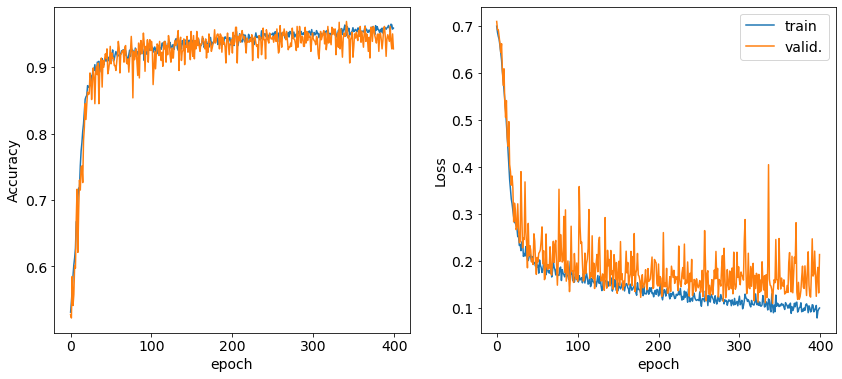

In [31]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
plt.savefig('performance-50_normal.png')

In [12]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),"******",len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50
print(grid_r)

pred = model.predict(grid_r)

51 ****** 2601
[50. 50.]
[[-1.   -1.  ]
 [-0.96 -1.  ]
 [-0.92 -1.  ]
 ...
 [ 0.92  1.  ]
 [ 0.96  1.  ]
 [ 1.    1.  ]]


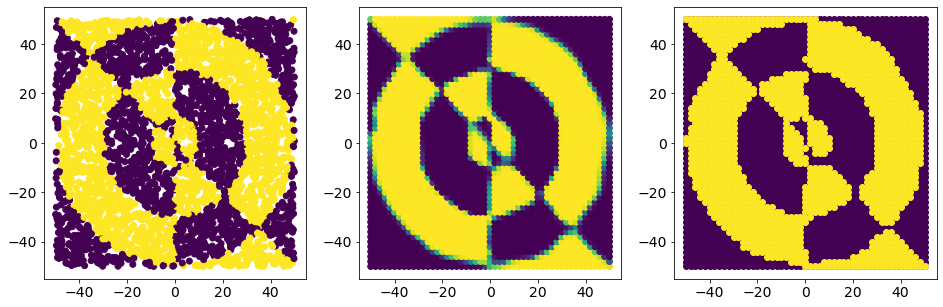

In [13]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
#boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
#boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
#boundaries()
plt.show
plt.show
plt.savefig('figure-50_normal2.png')

In [14]:
# evaluate model
score = model.evaluate(x_valid, y_valid, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 - 0s - loss: 0.1321 - accuracy: 0.9663

Test loss: 0.13205073773860931
Test accuracy: 0.9662500023841858


## CHANGING NORMALIZATION

Once we have obtained out final model we try how it performs over the data with different normalizations. Here we will train the data and show the score.

In [19]:
#Trainining with data normalized in a range

# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
#create_DNN(layers, activation, neurons_per_layer, dropout, optimizer,kernel_initializer):
# train DNN and store training info in history
fit=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          validation_data=(x_valid, y_valid))

Epoch 1/400
320/320 [==============================] - 4s 11ms/step - loss: 0.6930 - accuracy: 0.5366 - val_loss: 0.6863 - val_accuracy: 0.5587
Epoch 2/400
320/320 [==============================] - 3s 10ms/step - loss: 0.6804 - accuracy: 0.5647 - val_loss: 0.6816 - val_accuracy: 0.5638
Epoch 3/400
320/320 [==============================] - 2s 6ms/step - loss: 0.6708 - accuracy: 0.5897 - val_loss: 0.6636 - val_accuracy: 0.5800
Epoch 4/400
320/320 [==============================] - 1s 4ms/step - loss: 0.6583 - accuracy: 0.6153 - val_loss: 0.6619 - val_accuracy: 0.5863
Epoch 5/400
320/320 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6263 - val_loss: 0.6416 - val_accuracy: 0.6175
Epoch 6/400
320/320 [==============================] - 1s 4ms/step - loss: 0.6300 - accuracy: 0.6419 - val_loss: 0.6133 - val_accuracy: 0.6725
Epoch 7/400
320/320 [==============================] - 1s 5ms/step - loss: 0.5988 - accuracy: 0.6859 - val_loss: 0.5643 - val_accuracy: 0.72

Epoch 114/400
320/320 [==============================] - 3s 9ms/step - loss: 0.1879 - accuracy: 0.9184 - val_loss: 0.2642 - val_accuracy: 0.9087
Epoch 115/400
320/320 [==============================] - 2s 5ms/step - loss: 0.1800 - accuracy: 0.9244 - val_loss: 0.1993 - val_accuracy: 0.9400
Epoch 116/400
320/320 [==============================] - 1s 5ms/step - loss: 0.1785 - accuracy: 0.9197 - val_loss: 0.1849 - val_accuracy: 0.9337
Epoch 117/400
320/320 [==============================] - 1s 5ms/step - loss: 0.1649 - accuracy: 0.9275 - val_loss: 0.1954 - val_accuracy: 0.9300
Epoch 118/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1559 - accuracy: 0.9287 - val_loss: 0.3399 - val_accuracy: 0.8938
Epoch 119/400
320/320 [==============================] - 1s 5ms/step - loss: 0.1498 - accuracy: 0.9350 - val_loss: 0.1841 - val_accuracy: 0.9375
Epoch 120/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1720 - accuracy: 0.9244 - val_loss: 0.1740 - val_ac

320/320 [==============================] - 1s 4ms/step - loss: 0.1286 - accuracy: 0.9453 - val_loss: 0.1529 - val_accuracy: 0.9513
Epoch 227/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1379 - accuracy: 0.9425 - val_loss: 0.1673 - val_accuracy: 0.9425
Epoch 228/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1181 - accuracy: 0.9494 - val_loss: 0.2144 - val_accuracy: 0.9187
Epoch 229/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1271 - accuracy: 0.9409 - val_loss: 0.1703 - val_accuracy: 0.9450
Epoch 230/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1438 - accuracy: 0.9319 - val_loss: 0.1763 - val_accuracy: 0.9388
Epoch 231/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1291 - accuracy: 0.9419 - val_loss: 0.1533 - val_accuracy: 0.9488
Epoch 232/400
320/320 [==============================] - 2s 8ms/step - loss: 0.1430 - accuracy: 0.9400 - val_loss: 0.1959 - val_accuracy: 0.9337

320/320 [==============================] - 1s 3ms/step - loss: 0.1197 - accuracy: 0.9469 - val_loss: 0.1761 - val_accuracy: 0.9513
Epoch 339/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1191 - accuracy: 0.9488 - val_loss: 0.1550 - val_accuracy: 0.9463
Epoch 340/400
320/320 [==============================] - 1s 3ms/step - loss: 0.0981 - accuracy: 0.9575 - val_loss: 0.1515 - val_accuracy: 0.9475
Epoch 341/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1148 - accuracy: 0.9472 - val_loss: 0.1523 - val_accuracy: 0.9475
Epoch 342/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1144 - accuracy: 0.9500 - val_loss: 0.1415 - val_accuracy: 0.9563
Epoch 343/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1008 - accuracy: 0.9597 - val_loss: 0.1441 - val_accuracy: 0.9538
Epoch 344/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1180 - accuracy: 0.9500 - val_loss: 0.1718 - val_accuracy: 0.9450

In [20]:
# evaluate model
score = model.evaluate(x_valid, y_valid, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 - 0s - loss: 0.1394 - accuracy: 0.9563

Test loss: 0.13937781751155853
Test accuracy: 0.956250011920929


In [23]:
#Training with data normalized as a gaussian distribution
# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
#create_DNN(layers, activation, neurons_per_layer, dropout, optimizer,kernel_initializer):
# train DNN and store training info in history
fit=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          validation_data=(x_valid, y_valid))


Epoch 1/400
320/320 [==============================] - 2s 6ms/step - loss: 0.7030 - accuracy: 0.5250 - val_loss: 0.6953 - val_accuracy: 0.5150
Epoch 2/400
320/320 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.5475 - val_loss: 0.6865 - val_accuracy: 0.5263
Epoch 3/400
320/320 [==============================] - 1s 3ms/step - loss: 0.6671 - accuracy: 0.5916 - val_loss: 0.6719 - val_accuracy: 0.5650
Epoch 4/400
320/320 [==============================] - 1s 3ms/step - loss: 0.6491 - accuracy: 0.6081 - val_loss: 0.6366 - val_accuracy: 0.6200
Epoch 5/400
320/320 [==============================] - 1s 3ms/step - loss: 0.6233 - accuracy: 0.6397 - val_loss: 0.6664 - val_accuracy: 0.6162
Epoch 6/400
320/320 [==============================] - 1s 3ms/step - loss: 0.6086 - accuracy: 0.6538 - val_loss: 0.6226 - val_accuracy: 0.6025
Epoch 7/400
320/320 [==============================] - 1s 3ms/step - loss: 0.5954 - accuracy: 0.6587 - val_loss: 0.6010 - val_accuracy: 0.6538

Epoch 58/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1676 - accuracy: 0.9312 - val_loss: 0.2282 - val_accuracy: 0.9087
Epoch 59/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9275 - val_loss: 0.2895 - val_accuracy: 0.8863
Epoch 60/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1941 - accuracy: 0.9119 - val_loss: 0.1936 - val_accuracy: 0.9137
Epoch 61/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1697 - accuracy: 0.9253 - val_loss: 0.2133 - val_accuracy: 0.9050
Epoch 62/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1808 - accuracy: 0.9187 - val_loss: 0.2831 - val_accuracy: 0.8737
Epoch 63/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1859 - accuracy: 0.9194 - val_loss: 0.3400 - val_accuracy: 0.8712
Epoch 64/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1807 - accuracy: 0.9216 - val_loss: 0.2619 - val_accuracy:

320/320 [==============================] - 1s 4ms/step - loss: 0.1194 - accuracy: 0.9475 - val_loss: 0.1607 - val_accuracy: 0.9287s: 0.1164 
Epoch 171/400
320/320 [==============================] - 1s 3ms/step - loss: 0.1367 - accuracy: 0.9400 - val_loss: 0.2373 - val_accuracy: 0.8975
Epoch 172/400
320/320 [==============================] - 1s 5ms/step - loss: 0.1353 - accuracy: 0.9416 - val_loss: 0.2960 - val_accuracy: 0.8838
Epoch 173/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1277 - accuracy: 0.9450 - val_loss: 0.3525 - val_accuracy: 0.8800
Epoch 174/400
320/320 [==============================] - 2s 5ms/step - loss: 0.1311 - accuracy: 0.9397 - val_loss: 0.2548 - val_accuracy: 0.90620s - loss: 0.1275 - 
Epoch 175/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1278 - accuracy: 0.9456 - val_loss: 0.2813 - val_accuracy: 0.9087
Epoch 176/400
320/320 [==============================] - 1s 4ms/step - loss: 0.1212 - accuracy: 0.9466 - val_loss:

320/320 [==============================] - 1s 2ms/step - loss: 0.1150 - accuracy: 0.9478 - val_loss: 0.1936 - val_accuracy: 0.9225
Epoch 283/400
320/320 [==============================] - 3s 8ms/step - loss: 0.1005 - accuracy: 0.9584 - val_loss: 0.2937 - val_accuracy: 0.9137
Epoch 284/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1035 - accuracy: 0.9553 - val_loss: 0.4675 - val_accuracy: 0.8775
Epoch 285/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1179 - accuracy: 0.9513 - val_loss: 0.2799 - val_accuracy: 0.9000
Epoch 286/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1087 - accuracy: 0.9513 - val_loss: 0.3364 - val_accuracy: 0.8988
Epoch 287/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1062 - accuracy: 0.9541 - val_loss: 0.2262 - val_accuracy: 0.9162
Epoch 288/400
320/320 [==============================] - 2s 7ms/step - loss: 0.1286 - accuracy: 0.9463 - val_loss: 0.3934 - val_accuracy: 0.8788

320/320 [==============================] - 2s 6ms/step - loss: 0.0853 - accuracy: 0.9644 - val_loss: 0.1962 - val_accuracy: 0.9237
Epoch 395/400
320/320 [==============================] - 2s 6ms/step - loss: 0.0966 - accuracy: 0.9600 - val_loss: 0.2557 - val_accuracy: 0.9112
Epoch 396/400
320/320 [==============================] - 1s 4ms/step - loss: 0.0902 - accuracy: 0.9603 - val_loss: 0.2172 - val_accuracy: 0.9225
Epoch 397/400
320/320 [==============================] - 1s 4ms/step - loss: 0.0850 - accuracy: 0.9619 - val_loss: 0.3245 - val_accuracy: 0.8963
Epoch 398/400
320/320 [==============================] - 1s 4ms/step - loss: 0.0860 - accuracy: 0.9628 - val_loss: 0.2821 - val_accuracy: 0.9237
Epoch 399/400
320/320 [==============================] - 1s 4ms/step - loss: 0.0994 - accuracy: 0.9566 - val_loss: 0.2267 - val_accuracy: 0.9237
Epoch 400/400
320/320 [==============================] - 1s 4ms/step - loss: 0.0987 - accuracy: 0.9594 - val_loss: 0.2915 - val_accuracy: 0.9100

In [24]:
# evaluate model
score = model.evaluate(x_valid, y_valid, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 - 0s - loss: 0.2915 - accuracy: 0.9100

Test loss: 0.2915131747722626
Test accuracy: 0.9100000262260437


## DIFFERENT DATASETS

Now we will proceed to study how this model works over datasets of different sizes. The hyperparameters and normalization of this part are those which gave better results.

## REDUCTION OF DATA

2
[-31.60811883 -29.54397214] 1.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 400
train: 320


<function matplotlib.pyplot.show(close=None, block=None)>

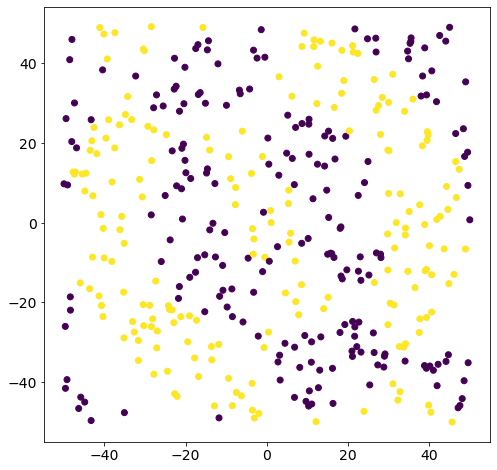

In [20]:
TYPE=2
x_red = np.loadtxt(filename_red("data",TYPE), delimiter=' ')
y_red = np.loadtxt(filename_red("labels",TYPE), delimiter=' ')
N_red = len(x_red)

# dim. of a sample
L = len(x_red[0])
print(L)

for i in range(10):
    print(x_red[i],y_red[i])

N_train_red = int(perc_train * N_red)
print(f'data: {N_red}\ntrain: {N_train_red}')

plt.figure(figsize = (8,8))
plt.scatter(x_red[:,0],x_red[:,1],c=y_red) #tutte le righe della colonna 0, tutte le righe della colonna 1
plt.show

### split in train and test set

In [21]:
(x_train_red, y_train_red) = (x_red[0:N_train_red],y_red[0:N_train_red])
(x_valid_red, y_valid_red) = (x_red[N_train_red:],y_red[N_train_red:])
print("Train:",len(x_train_red),"\t Validation:",len(x_valid_red))

Train: 320 	 Validation: 80


### Rescale of data

In [22]:
x_train_red = Rescale(x_train_red)
x_valid_red = Rescale(x_valid_red)

### Training of model

In [23]:
# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
# train DNN and store training info in history
fit=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          verbose=2,
          validation_data=(x_valid_red, y_valid_red))

Epoch 1/400
320/320 - 3s - loss: 0.6978 - accuracy: 0.5241 - val_loss: 0.6986 - val_accuracy: 0.5625
Epoch 2/400
320/320 - 2s - loss: 0.6861 - accuracy: 0.5487 - val_loss: 0.7250 - val_accuracy: 0.4000
Epoch 3/400
320/320 - 2s - loss: 0.6763 - accuracy: 0.5763 - val_loss: 0.7023 - val_accuracy: 0.5500
Epoch 4/400
320/320 - 1s - loss: 0.6673 - accuracy: 0.5984 - val_loss: 0.6714 - val_accuracy: 0.6125
Epoch 5/400
320/320 - 1s - loss: 0.6505 - accuracy: 0.6200 - val_loss: 0.6550 - val_accuracy: 0.6875
Epoch 6/400
320/320 - 1s - loss: 0.6331 - accuracy: 0.6338 - val_loss: 0.6571 - val_accuracy: 0.6250
Epoch 7/400
320/320 - 1s - loss: 0.6049 - accuracy: 0.6637 - val_loss: 0.5560 - val_accuracy: 0.7750
Epoch 8/400
320/320 - 1s - loss: 0.5800 - accuracy: 0.6831 - val_loss: 0.5970 - val_accuracy: 0.6625
Epoch 9/400
320/320 - 1s - loss: 0.5589 - accuracy: 0.6966 - val_loss: 0.6076 - val_accuracy: 0.6750
Epoch 10/400
320/320 - 1s - loss: 0.5431 - accuracy: 0.7147 - val_loss: 0.4626 - val_accura

Epoch 82/400
320/320 - 1s - loss: 0.1782 - accuracy: 0.9222 - val_loss: 0.0923 - val_accuracy: 0.9500
Epoch 83/400
320/320 - 1s - loss: 0.1679 - accuracy: 0.9300 - val_loss: 0.1582 - val_accuracy: 0.9125
Epoch 84/400
320/320 - 1s - loss: 0.1685 - accuracy: 0.9231 - val_loss: 0.1064 - val_accuracy: 0.9625
Epoch 85/400
320/320 - 1s - loss: 0.1977 - accuracy: 0.9172 - val_loss: 0.1285 - val_accuracy: 0.9250
Epoch 86/400
320/320 - 1s - loss: 0.1872 - accuracy: 0.9184 - val_loss: 0.1202 - val_accuracy: 0.9750
Epoch 87/400
320/320 - 1s - loss: 0.1627 - accuracy: 0.9297 - val_loss: 0.2199 - val_accuracy: 0.8875
Epoch 88/400
320/320 - 1s - loss: 0.1714 - accuracy: 0.9250 - val_loss: 0.1322 - val_accuracy: 0.9625
Epoch 89/400
320/320 - 1s - loss: 0.1733 - accuracy: 0.9209 - val_loss: 0.1070 - val_accuracy: 0.9625
Epoch 90/400
320/320 - 1s - loss: 0.1838 - accuracy: 0.9175 - val_loss: 0.2798 - val_accuracy: 0.9000
Epoch 91/400
320/320 - 1s - loss: 0.1605 - accuracy: 0.9297 - val_loss: 0.1839 - v

Epoch 162/400
320/320 - 1s - loss: 0.1420 - accuracy: 0.9413 - val_loss: 0.0911 - val_accuracy: 0.9625
Epoch 163/400
320/320 - 1s - loss: 0.1417 - accuracy: 0.9391 - val_loss: 0.2323 - val_accuracy: 0.9125
Epoch 164/400
320/320 - 1s - loss: 0.1574 - accuracy: 0.9281 - val_loss: 0.1252 - val_accuracy: 0.9750
Epoch 165/400
320/320 - 1s - loss: 0.1477 - accuracy: 0.9344 - val_loss: 0.1215 - val_accuracy: 0.9750
Epoch 166/400
320/320 - 1s - loss: 0.1457 - accuracy: 0.9400 - val_loss: 0.2097 - val_accuracy: 0.9000
Epoch 167/400
320/320 - 1s - loss: 0.1313 - accuracy: 0.9400 - val_loss: 0.1846 - val_accuracy: 0.9250
Epoch 168/400
320/320 - 1s - loss: 0.1448 - accuracy: 0.9347 - val_loss: 0.1234 - val_accuracy: 0.9500
Epoch 169/400
320/320 - 1s - loss: 0.1448 - accuracy: 0.9359 - val_loss: 0.0787 - val_accuracy: 0.9750
Epoch 170/400
320/320 - 1s - loss: 0.1398 - accuracy: 0.9369 - val_loss: 0.1700 - val_accuracy: 0.8750
Epoch 171/400
320/320 - 1s - loss: 0.1406 - accuracy: 0.9391 - val_loss: 

Epoch 242/400
320/320 - 1s - loss: 0.1256 - accuracy: 0.9463 - val_loss: 0.0533 - val_accuracy: 0.9875
Epoch 243/400
320/320 - 1s - loss: 0.1296 - accuracy: 0.9459 - val_loss: 0.0683 - val_accuracy: 0.9625
Epoch 244/400
320/320 - 1s - loss: 0.1280 - accuracy: 0.9428 - val_loss: 0.0811 - val_accuracy: 0.9750
Epoch 245/400
320/320 - 1s - loss: 0.1284 - accuracy: 0.9453 - val_loss: 0.1000 - val_accuracy: 0.9500
Epoch 246/400
320/320 - 1s - loss: 0.1210 - accuracy: 0.9475 - val_loss: 0.0894 - val_accuracy: 0.9625
Epoch 247/400
320/320 - 1s - loss: 0.1324 - accuracy: 0.9438 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 248/400
320/320 - 1s - loss: 0.1225 - accuracy: 0.9469 - val_loss: 0.1513 - val_accuracy: 0.9375
Epoch 249/400
320/320 - 1s - loss: 0.1291 - accuracy: 0.9466 - val_loss: 0.1731 - val_accuracy: 0.9375
Epoch 250/400
320/320 - 3s - loss: 0.1337 - accuracy: 0.9413 - val_loss: 0.0401 - val_accuracy: 0.9875
Epoch 251/400
320/320 - 1s - loss: 0.1287 - accuracy: 0.9419 - val_loss: 

Epoch 322/400
320/320 - 1s - loss: 0.1205 - accuracy: 0.9478 - val_loss: 0.1092 - val_accuracy: 0.9375
Epoch 323/400
320/320 - 1s - loss: 0.1232 - accuracy: 0.9494 - val_loss: 0.1364 - val_accuracy: 0.9375
Epoch 324/400
320/320 - 1s - loss: 0.1172 - accuracy: 0.9491 - val_loss: 0.0442 - val_accuracy: 0.9875
Epoch 325/400
320/320 - 1s - loss: 0.1065 - accuracy: 0.9556 - val_loss: 0.0691 - val_accuracy: 0.9875
Epoch 326/400
320/320 - 1s - loss: 0.1144 - accuracy: 0.9525 - val_loss: 0.0622 - val_accuracy: 0.9750
Epoch 327/400
320/320 - 1s - loss: 0.1117 - accuracy: 0.9519 - val_loss: 0.0377 - val_accuracy: 1.0000
Epoch 328/400
320/320 - 1s - loss: 0.1180 - accuracy: 0.9484 - val_loss: 0.1413 - val_accuracy: 0.9000
Epoch 329/400
320/320 - 1s - loss: 0.1209 - accuracy: 0.9466 - val_loss: 0.0485 - val_accuracy: 0.9875
Epoch 330/400
320/320 - 1s - loss: 0.1185 - accuracy: 0.9491 - val_loss: 0.0996 - val_accuracy: 0.9500
Epoch 331/400
320/320 - 1s - loss: 0.1067 - accuracy: 0.9556 - val_loss: 

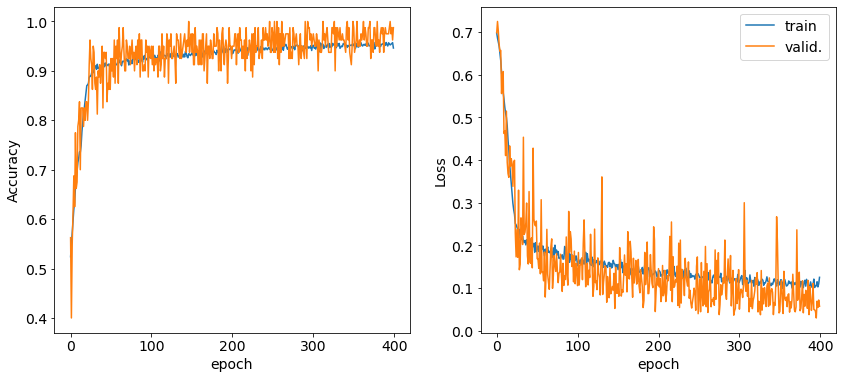

In [24]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
plt.savefig('performance-50_red.png')

In [25]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),"******",len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50
print(grid_r)

pred = model.predict(grid_r)

51 ****** 2601
[50. 50.]
[[-1.   -1.  ]
 [-0.96 -1.  ]
 [-0.92 -1.  ]
 ...
 [ 0.92  1.  ]
 [ 0.96  1.  ]
 [ 1.    1.  ]]


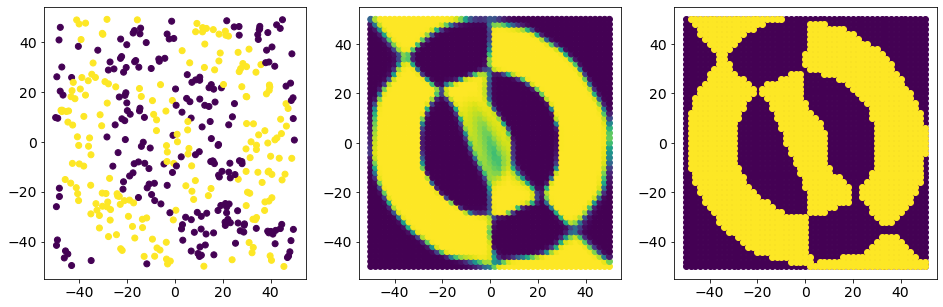

In [26]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x_red[:,0],x_red[:,1],c=y_red)
#boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
#boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
#boundaries()
plt.show
plt.show
plt.savefig('figure-50_red.png')

In [27]:
# evaluate model
score = model.evaluate(x_valid_red, y_valid_red, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 - 0s - loss: 0.0574 - accuracy: 0.9875

Test loss: 0.057437825947999954
Test accuracy: 0.987500011920929


## INCREMENTATION OF DATA


2
[-31.60811883 -29.54397214] 1.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 10000
train: 8000


<function matplotlib.pyplot.show(close=None, block=None)>

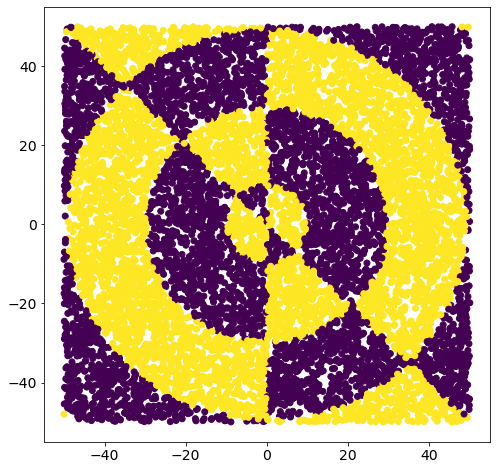

In [28]:
TYPE=2
x_incr = np.loadtxt(filename_incr("data",TYPE), delimiter=' ')
y_incr = np.loadtxt(filename_incr("labels",TYPE), delimiter=' ')
N_incr = len(x_incr)

# dim. of a sample
L = len(x_incr[0])
print(L)

for i in range(10):
    print(x_incr[i],y_incr[i])

N_train_incr = int(perc_train * N_incr)
print(f'data: {N_incr}\ntrain: {N_train_incr}')

plt.figure(figsize = (8,8))
plt.scatter(x_incr[:,0],x_incr[:,1],c=y_incr) #tutte le righe della colonna 0, tutte le righe della colonna 1
plt.show

### split in train and test set

In [29]:
(x_train_incr, y_train_incr) = (x_incr[0:N_train_incr],y_incr[0:N_train_incr])
(x_valid_incr, y_valid_incr) = (x_incr[N_train_incr:],y_incr[N_train_incr:])
print("Train:",len(x_train_incr),"\t Validation:",len(x_valid_incr))

Train: 8000 	 Validation: 2000


### Rescale of data

In [30]:
x_train_incr = Rescale(x_train_incr)
x_valid_incr = Rescale(x_valid_incr)

### Training of model

In [31]:
# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
#create_DNN(layers, activation, neurons_per_layer, dropout, optimizer,kernel_initializer):
# train DNN and store training info in history
fit_incr=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          verbose=2,
          validation_data=(x_valid_incr, y_valid_incr))

Epoch 1/400
320/320 - 2s - loss: 0.6919 - accuracy: 0.5500 - val_loss: 0.7030 - val_accuracy: 0.5670
Epoch 2/400
320/320 - 2s - loss: 0.6756 - accuracy: 0.5691 - val_loss: 0.6760 - val_accuracy: 0.5615
Epoch 3/400
320/320 - 2s - loss: 0.6558 - accuracy: 0.5972 - val_loss: 0.6541 - val_accuracy: 0.6125
Epoch 4/400
320/320 - 2s - loss: 0.6365 - accuracy: 0.6297 - val_loss: 0.6282 - val_accuracy: 0.6015
Epoch 5/400
320/320 - 3s - loss: 0.6118 - accuracy: 0.6428 - val_loss: 0.6277 - val_accuracy: 0.6230
Epoch 6/400
320/320 - 1s - loss: 0.5955 - accuracy: 0.6422 - val_loss: 0.6018 - val_accuracy: 0.6480
Epoch 7/400
320/320 - 2s - loss: 0.5779 - accuracy: 0.6562 - val_loss: 0.6054 - val_accuracy: 0.6240
Epoch 8/400
320/320 - 2s - loss: 0.5755 - accuracy: 0.6531 - val_loss: 0.5582 - val_accuracy: 0.6615
Epoch 9/400
320/320 - 2s - loss: 0.5602 - accuracy: 0.6747 - val_loss: 0.5406 - val_accuracy: 0.6850
Epoch 10/400
320/320 - 2s - loss: 0.5463 - accuracy: 0.6816 - val_loss: 0.5594 - val_accura

Epoch 82/400
320/320 - 2s - loss: 0.1697 - accuracy: 0.9266 - val_loss: 0.1864 - val_accuracy: 0.9160
Epoch 83/400
320/320 - 2s - loss: 0.1718 - accuracy: 0.9259 - val_loss: 0.2499 - val_accuracy: 0.9040
Epoch 84/400
320/320 - 2s - loss: 0.1574 - accuracy: 0.9316 - val_loss: 0.2001 - val_accuracy: 0.9110
Epoch 85/400
320/320 - 2s - loss: 0.1720 - accuracy: 0.9262 - val_loss: 0.1679 - val_accuracy: 0.9185
Epoch 86/400
320/320 - 2s - loss: 0.1523 - accuracy: 0.9334 - val_loss: 0.1618 - val_accuracy: 0.9340
Epoch 87/400
320/320 - 1s - loss: 0.1613 - accuracy: 0.9281 - val_loss: 0.2198 - val_accuracy: 0.9140
Epoch 88/400
320/320 - 1s - loss: 0.1622 - accuracy: 0.9312 - val_loss: 0.1852 - val_accuracy: 0.9225
Epoch 89/400
320/320 - 1s - loss: 0.1554 - accuracy: 0.9294 - val_loss: 0.1811 - val_accuracy: 0.9270
Epoch 90/400
320/320 - 1s - loss: 0.1607 - accuracy: 0.9350 - val_loss: 0.2322 - val_accuracy: 0.9050
Epoch 91/400
320/320 - 1s - loss: 0.1550 - accuracy: 0.9306 - val_loss: 0.1702 - v

Epoch 162/400
320/320 - 1s - loss: 0.1469 - accuracy: 0.9394 - val_loss: 0.1493 - val_accuracy: 0.9390
Epoch 163/400
320/320 - 2s - loss: 0.1254 - accuracy: 0.9509 - val_loss: 0.1584 - val_accuracy: 0.9295
Epoch 164/400
320/320 - 2s - loss: 0.1372 - accuracy: 0.9413 - val_loss: 0.2715 - val_accuracy: 0.8885
Epoch 165/400
320/320 - 1s - loss: 0.1537 - accuracy: 0.9334 - val_loss: 0.2105 - val_accuracy: 0.9195
Epoch 166/400
320/320 - 1s - loss: 0.1283 - accuracy: 0.9456 - val_loss: 0.1365 - val_accuracy: 0.9455
Epoch 167/400
320/320 - 1s - loss: 0.1235 - accuracy: 0.9459 - val_loss: 0.1493 - val_accuracy: 0.9355
Epoch 168/400
320/320 - 2s - loss: 0.1297 - accuracy: 0.9409 - val_loss: 0.1429 - val_accuracy: 0.9385
Epoch 169/400
320/320 - 1s - loss: 0.1356 - accuracy: 0.9406 - val_loss: 0.1595 - val_accuracy: 0.9350
Epoch 170/400
320/320 - 1s - loss: 0.1336 - accuracy: 0.9450 - val_loss: 0.2101 - val_accuracy: 0.9190
Epoch 171/400
320/320 - 2s - loss: 0.1396 - accuracy: 0.9388 - val_loss: 

Epoch 242/400
320/320 - 1s - loss: 0.1105 - accuracy: 0.9481 - val_loss: 0.1785 - val_accuracy: 0.9285
Epoch 243/400
320/320 - 1s - loss: 0.1267 - accuracy: 0.9431 - val_loss: 0.1292 - val_accuracy: 0.9490
Epoch 244/400
320/320 - 1s - loss: 0.1206 - accuracy: 0.9513 - val_loss: 0.1254 - val_accuracy: 0.9485
Epoch 245/400
320/320 - 1s - loss: 0.1093 - accuracy: 0.9513 - val_loss: 0.1693 - val_accuracy: 0.9350
Epoch 246/400
320/320 - 1s - loss: 0.1047 - accuracy: 0.9566 - val_loss: 0.1341 - val_accuracy: 0.9415
Epoch 247/400
320/320 - 2s - loss: 0.1174 - accuracy: 0.9472 - val_loss: 0.1448 - val_accuracy: 0.9380
Epoch 248/400
320/320 - 1s - loss: 0.1151 - accuracy: 0.9484 - val_loss: 0.1538 - val_accuracy: 0.9345
Epoch 249/400
320/320 - 2s - loss: 0.1071 - accuracy: 0.9541 - val_loss: 0.1521 - val_accuracy: 0.9375
Epoch 250/400
320/320 - 2s - loss: 0.1137 - accuracy: 0.9550 - val_loss: 0.1465 - val_accuracy: 0.9375
Epoch 251/400
320/320 - 1s - loss: 0.1119 - accuracy: 0.9491 - val_loss: 

Epoch 322/400
320/320 - 2s - loss: 0.1117 - accuracy: 0.9550 - val_loss: 0.1316 - val_accuracy: 0.9445
Epoch 323/400
320/320 - 2s - loss: 0.0915 - accuracy: 0.9597 - val_loss: 0.1109 - val_accuracy: 0.9575
Epoch 324/400
320/320 - 2s - loss: 0.1051 - accuracy: 0.9588 - val_loss: 0.1359 - val_accuracy: 0.9370
Epoch 325/400
320/320 - 2s - loss: 0.0965 - accuracy: 0.9609 - val_loss: 0.1272 - val_accuracy: 0.9480
Epoch 326/400
320/320 - 2s - loss: 0.0984 - accuracy: 0.9606 - val_loss: 0.1175 - val_accuracy: 0.9450
Epoch 327/400
320/320 - 2s - loss: 0.1097 - accuracy: 0.9541 - val_loss: 0.1849 - val_accuracy: 0.9295
Epoch 328/400
320/320 - 2s - loss: 0.1099 - accuracy: 0.9513 - val_loss: 0.2479 - val_accuracy: 0.9175
Epoch 329/400
320/320 - 2s - loss: 0.0972 - accuracy: 0.9606 - val_loss: 0.1265 - val_accuracy: 0.9490
Epoch 330/400
320/320 - 2s - loss: 0.1053 - accuracy: 0.9591 - val_loss: 0.1057 - val_accuracy: 0.9545
Epoch 331/400
320/320 - 2s - loss: 0.0952 - accuracy: 0.9588 - val_loss: 

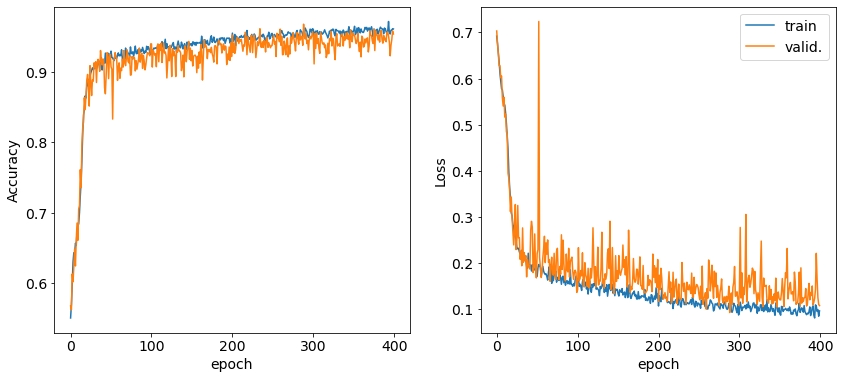

In [32]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit_incr.history['accuracy'],label="train")
ax.plot(fit_incr.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit_incr.history['loss'],label="train")
ax.plot(fit_incr.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
plt.savefig('performance-50_incr.png')

In [33]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),"******",len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50
print(grid_r)

pred = model.predict(grid_r)

51 ****** 2601
[50. 50.]
[[-1.   -1.  ]
 [-0.96 -1.  ]
 [-0.92 -1.  ]
 ...
 [ 0.92  1.  ]
 [ 0.96  1.  ]
 [ 1.    1.  ]]


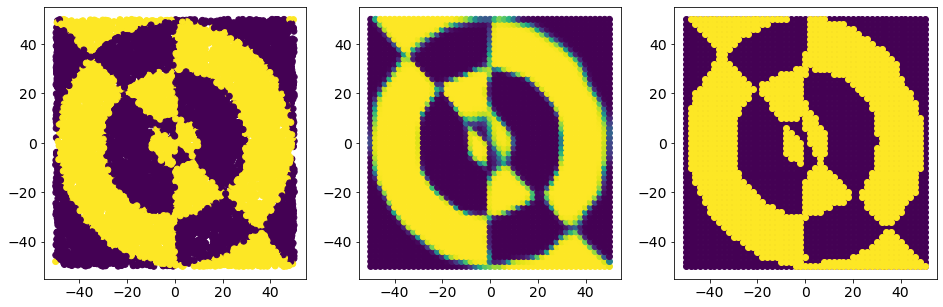

In [35]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x_incr[:,0],x_incr[:,1],c=y_incr)
#boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
#boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
#boundaries()
plt.show
plt.show
plt.savefig('figure-50_incr.png')

In [36]:
# evaluate model
score = model.evaluate(x_valid_incr, y_valid_incr, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 - 0s - loss: 0.1081 - accuracy: 0.9540

Test loss: 0.10812172293663025
Test accuracy: 0.9539999961853027


## AUGMENTATION OF DATA

X augmentated: (8000, 2)
2
[-31.60811883 -29.54397214] 1.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 8000
train: 6400


<function matplotlib.pyplot.show(close=None, block=None)>

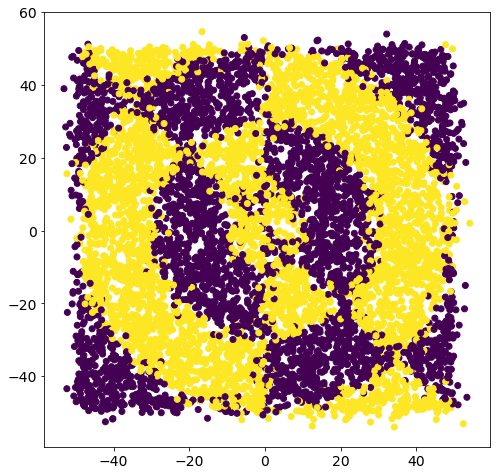

In [37]:
TYPE=2
x_aug = np.loadtxt(filename("data",TYPE), delimiter=' ')      #non serve creare una nuova cartella, i dati vengono presi dalla cartella iniziale 'DATA' 
y_aug = np.loadtxt(filename("labels",TYPE), delimiter=' ')

#creating noise
x1_noise = np.random.normal(0,2,4000)
x2_noise = np.random.normal(0,2,4000)
x_noise = np.array((x1_noise,x2_noise)).T

#concatenating noise+samples
x_aug = np.concatenate((x_aug,x_aug+x_noise))
y_aug = np.concatenate((y_aug,y_aug))
print("X augmentated:",x_aug.shape) 

N_aug = len(x_aug)

# dim. of a sample
L = len(x_aug[0])
print(L)

for i in range(10):
    print(x_aug[i],y_aug[i])

N_train_aug = int(perc_train * N_aug)
print(f'data: {N_aug}\ntrain: {N_train_aug}')

plt.figure(figsize = (8,8))
plt.scatter(x_aug[:,0],x_aug[:,1],c=y_aug) #tutte le righe della colonna 0, tutte le righe della colonna 1
plt.show

### split in train and test set

In [38]:
(x_train_aug, y_train_aug) = (x_aug[0:N_train_aug],y_aug[0:N_train_aug])
(x_valid_aug, y_valid_aug) = (x_aug[N_train_aug:],y_aug[N_train_aug:])
print("Train:",len(x_train_aug),"\t Validation:",len(x_valid_aug))

Train: 6400 	 Validation: 1600


### Rescale of data

In [39]:
x_train_aug = Rescale(x_train_aug)
x_valid_aug = Rescale(x_valid_aug)

### Training of model

In [40]:
# create the deep neural net
model=create_DNN(layer = (200,100,50,25), activ='selu', drop= 0,optimizer ='Nadam',kernel_initializer ='glorot_normal') #best parameters for now
#create_DNN(layers, activation, neurons_per_layer, dropout, optimizer,kernel_initializer):
# train DNN and store training info in history
fit_aug=model.fit(x_train, y_train,
          batch_size=10,
          epochs=nepoch,
          verbose=2,
          validation_data=(x_valid_aug, y_valid_aug))

Epoch 1/400
320/320 - 3s - loss: 0.7000 - accuracy: 0.5200 - val_loss: 0.6900 - val_accuracy: 0.5350
Epoch 2/400
320/320 - 3s - loss: 0.6903 - accuracy: 0.5378 - val_loss: 0.7098 - val_accuracy: 0.5444
Epoch 3/400
320/320 - 3s - loss: 0.6843 - accuracy: 0.5487 - val_loss: 0.6956 - val_accuracy: 0.5256
Epoch 4/400
320/320 - 2s - loss: 0.6761 - accuracy: 0.5750 - val_loss: 0.6680 - val_accuracy: 0.5281
Epoch 5/400
320/320 - 2s - loss: 0.6480 - accuracy: 0.6087 - val_loss: 0.6273 - val_accuracy: 0.6662
Epoch 6/400
320/320 - 2s - loss: 0.6153 - accuracy: 0.6634 - val_loss: 0.6329 - val_accuracy: 0.6294
Epoch 7/400
320/320 - 2s - loss: 0.5911 - accuracy: 0.6741 - val_loss: 0.6209 - val_accuracy: 0.6481
Epoch 8/400
320/320 - 2s - loss: 0.5794 - accuracy: 0.6784 - val_loss: 0.5671 - val_accuracy: 0.6812
Epoch 9/400
320/320 - 2s - loss: 0.5621 - accuracy: 0.6928 - val_loss: 0.5592 - val_accuracy: 0.6756
Epoch 10/400
320/320 - 2s - loss: 0.5458 - accuracy: 0.7047 - val_loss: 0.5609 - val_accura

Epoch 82/400
320/320 - 2s - loss: 0.1936 - accuracy: 0.9141 - val_loss: 0.4346 - val_accuracy: 0.8481
Epoch 83/400
320/320 - 2s - loss: 0.1939 - accuracy: 0.9175 - val_loss: 0.3926 - val_accuracy: 0.8500
Epoch 84/400
320/320 - 2s - loss: 0.2015 - accuracy: 0.9116 - val_loss: 0.4026 - val_accuracy: 0.8587
Epoch 85/400
320/320 - 2s - loss: 0.1801 - accuracy: 0.9216 - val_loss: 0.3826 - val_accuracy: 0.8625
Epoch 86/400
320/320 - 2s - loss: 0.1810 - accuracy: 0.9194 - val_loss: 0.3246 - val_accuracy: 0.8756
Epoch 87/400
320/320 - 2s - loss: 0.1840 - accuracy: 0.9166 - val_loss: 0.4077 - val_accuracy: 0.8519
Epoch 88/400
320/320 - 2s - loss: 0.2040 - accuracy: 0.9078 - val_loss: 0.3646 - val_accuracy: 0.8631
Epoch 89/400
320/320 - 2s - loss: 0.1846 - accuracy: 0.9222 - val_loss: 0.4125 - val_accuracy: 0.8519
Epoch 90/400
320/320 - 2s - loss: 0.1848 - accuracy: 0.9191 - val_loss: 0.3984 - val_accuracy: 0.8644
Epoch 91/400
320/320 - 2s - loss: 0.1935 - accuracy: 0.9203 - val_loss: 0.3498 - v

Epoch 162/400
320/320 - 1s - loss: 0.1710 - accuracy: 0.9266 - val_loss: 0.4201 - val_accuracy: 0.8550
Epoch 163/400
320/320 - 1s - loss: 0.1540 - accuracy: 0.9319 - val_loss: 0.3592 - val_accuracy: 0.8794
Epoch 164/400
320/320 - 1s - loss: 0.1502 - accuracy: 0.9312 - val_loss: 0.3350 - val_accuracy: 0.8825
Epoch 165/400
320/320 - 1s - loss: 0.1517 - accuracy: 0.9356 - val_loss: 0.4452 - val_accuracy: 0.8537
Epoch 166/400
320/320 - 1s - loss: 0.1597 - accuracy: 0.9284 - val_loss: 0.3856 - val_accuracy: 0.8794
Epoch 167/400
320/320 - 1s - loss: 0.1602 - accuracy: 0.9341 - val_loss: 0.3598 - val_accuracy: 0.8788
Epoch 168/400
320/320 - 1s - loss: 0.1536 - accuracy: 0.9341 - val_loss: 0.3929 - val_accuracy: 0.8675
Epoch 169/400
320/320 - 1s - loss: 0.1456 - accuracy: 0.9347 - val_loss: 0.3548 - val_accuracy: 0.8806
Epoch 170/400
320/320 - 1s - loss: 0.1484 - accuracy: 0.9381 - val_loss: 0.4326 - val_accuracy: 0.8637
Epoch 171/400
320/320 - 1s - loss: 0.1624 - accuracy: 0.9294 - val_loss: 

Epoch 242/400
320/320 - 1s - loss: 0.1337 - accuracy: 0.9422 - val_loss: 0.3820 - val_accuracy: 0.8813
Epoch 243/400
320/320 - 1s - loss: 0.1379 - accuracy: 0.9406 - val_loss: 0.3998 - val_accuracy: 0.8794
Epoch 244/400
320/320 - 1s - loss: 0.1453 - accuracy: 0.9375 - val_loss: 0.3917 - val_accuracy: 0.8794
Epoch 245/400
320/320 - 1s - loss: 0.1228 - accuracy: 0.9425 - val_loss: 0.3789 - val_accuracy: 0.8850
Epoch 246/400
320/320 - 1s - loss: 0.1295 - accuracy: 0.9441 - val_loss: 0.3910 - val_accuracy: 0.8813
Epoch 247/400
320/320 - 1s - loss: 0.1226 - accuracy: 0.9491 - val_loss: 0.3686 - val_accuracy: 0.8925
Epoch 248/400
320/320 - 1s - loss: 0.1242 - accuracy: 0.9491 - val_loss: 0.4702 - val_accuracy: 0.8656
Epoch 249/400
320/320 - 1s - loss: 0.1529 - accuracy: 0.9381 - val_loss: 0.4073 - val_accuracy: 0.8750
Epoch 250/400
320/320 - 1s - loss: 0.1318 - accuracy: 0.9441 - val_loss: 0.4050 - val_accuracy: 0.8825
Epoch 251/400
320/320 - 1s - loss: 0.1427 - accuracy: 0.9369 - val_loss: 

Epoch 322/400
320/320 - 1s - loss: 0.1148 - accuracy: 0.9484 - val_loss: 0.4187 - val_accuracy: 0.8781
Epoch 323/400
320/320 - 1s - loss: 0.1211 - accuracy: 0.9494 - val_loss: 0.4698 - val_accuracy: 0.8694
Epoch 324/400
320/320 - 1s - loss: 0.1135 - accuracy: 0.9534 - val_loss: 0.4074 - val_accuracy: 0.8775
Epoch 325/400
320/320 - 1s - loss: 0.1223 - accuracy: 0.9475 - val_loss: 0.4481 - val_accuracy: 0.8681
Epoch 326/400
320/320 - 1s - loss: 0.1049 - accuracy: 0.9547 - val_loss: 0.4227 - val_accuracy: 0.8819
Epoch 327/400
320/320 - 1s - loss: 0.1247 - accuracy: 0.9469 - val_loss: 0.3955 - val_accuracy: 0.8831
Epoch 328/400
320/320 - 1s - loss: 0.1188 - accuracy: 0.9453 - val_loss: 0.4014 - val_accuracy: 0.8850
Epoch 329/400
320/320 - 1s - loss: 0.1186 - accuracy: 0.9469 - val_loss: 0.4821 - val_accuracy: 0.8612
Epoch 330/400
320/320 - 1s - loss: 0.1227 - accuracy: 0.9441 - val_loss: 0.4075 - val_accuracy: 0.8850
Epoch 331/400
320/320 - 1s - loss: 0.1180 - accuracy: 0.9519 - val_loss: 

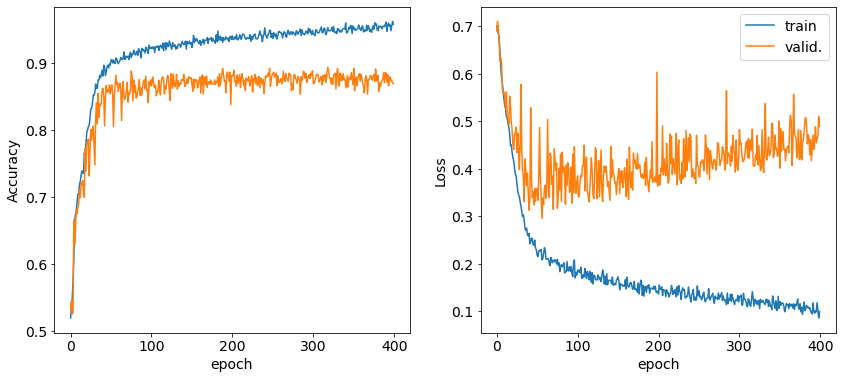

In [41]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit_aug.history['accuracy'],label="train")
ax.plot(fit_aug.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit_aug.history['loss'],label="train")
ax.plot(fit_aug.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()
plt.savefig('performance-50_aug.png')

In [42]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),"******",len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50
print(grid_r)

pred = model.predict(grid_r)

51 ****** 2601
[50. 50.]
[[-1.   -1.  ]
 [-0.96 -1.  ]
 [-0.92 -1.  ]
 ...
 [ 0.92  1.  ]
 [ 0.96  1.  ]
 [ 1.    1.  ]]


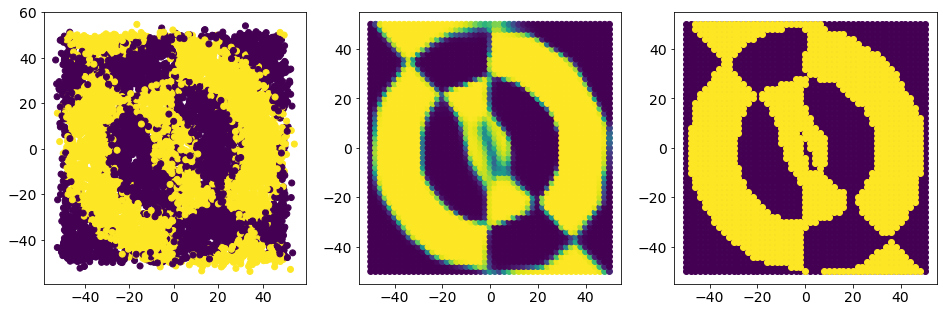

In [43]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x_aug[:,0],x_aug[:,1],c=y_aug)
#boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
#boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
#boundaries()
plt.show
plt.show
plt.savefig('figure-50_aug.png')

In [44]:
# evaluate model
score = model.evaluate(x_valid_aug, y_valid_aug, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

50/50 - 0s - loss: 0.4885 - accuracy: 0.8694

Test loss: 0.48845672607421875
Test accuracy: 0.8693749904632568
